# NYC Rideshare Forecasting Pipeline - Part 3: Exploratory Analysis

**Author:** K Flowers  
**GitHub:** [github.com/KRFlowers](https://github.com/KRFlowers)  
**Date:** January 2026

This notebook aggregates validated NYC rideshare trip records to daily counts by zone and analyzes demand patterns using a two-level approach: system-wide (global) trends first, then individual zone characteristics. The analysis identifies seasonal patterns and zone-level stability for forecasting model selection.

**Pipeline Position:** Notebook 3 of 4: Exploratory Analysis
- 00_data_download.ipynb
- 01_data_validation.ipynb
- 02_exploratory_analysis.ipynb ← **this notebook**
- 03_demand_forecasting.ipynb

**Objective:** Identify shared temporal patterns and zone-specific characteristics to guide forecasting model selection and feature engineering.

**Technical Approach:**
- Aggregate 683M trip records to daily zone-level counts
- Analyze global demand patterns (all zones combined)
- Examine zone-specific volume, variability, and correlations
- Calculate stability metrics (CV) and correlation matrices

**Inputs:**
- `data/validated/fhvhv_valid_data_for_eda.parquet` — Validated trip records (683M records)

**Outputs:**
- `data/processed/zone_daily.parquet` — Daily demand by zone with calendar features
- `data/processed/zone_stats_summary.csv` — Zone-level summary statistics

**Runtime:** ~5 minutes


**Purpose:** Analyze validated NYC rideshare trip data to identify demand patterns for multi-series time series forecasting by zone.

**Key Questions:**
- What temporal patterns (trend/seasonality) are shared system-wide?
- How much do zones differ in volume and variability?
- Do any zones materially deviate from the global seasonal profile?

**Approach:**
1. Aggregate trips to daily zone-level counts
2. Analyze global demand patterns (all zones combined)
3. Examine zone-specific characteristics and deviations

**Outputs:**
- `data/processed/zone_daily.parquet` — Daily demand by zone with calendar features
- `data/processed/zone_stats_summary.csv` — Zone-level summary statistics

## 1. Configure Environment

### 1.1 Import Libraries

In [33]:
# Core libraries
import pandas as pd
import numpy as np
import duckdb
from pathlib import Path
from pandas.tseries.holiday import USFederalHolidayCalendar

# Visualization
import matplotlib.pyplot as plt

# Utilities
import warnings

print("Libraries imported successfully")

Libraries imported successfully


### 1.2 Set Display and Plot Options

In [34]:
# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Visualization settings
%matplotlib inline

warnings.filterwarnings('ignore')

### 1.3 Set Paths and Constants

In [35]:
# Set constants
PROJECT_YEARS = [2022, 2023, 2024]
TLC_DATASET = 'fhvhv'

# Set file paths
PROJECT_ROOT = Path("..").resolve()
RAW_DIR = PROJECT_ROOT / "data" / "raw"
VALIDATED_DIR = PROJECT_ROOT / "data" / "validated"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

# Create input/output file paths
INPUT_FILE = VALIDATED_DIR / f"{TLC_DATASET}_valid_data_for_eda.parquet"
OUTPUT_FILE = PROCESSED_DIR / "zone_daily.parquet"
ZONE_STATS_FILE = PROCESSED_DIR / "zone_stats_summary.csv"

# Create directories
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Config loaded: {INPUT_FILE.name}")

Config loaded: fhvhv_valid_data_for_eda.parquet


### 1.4 Create Database Connection

In [36]:
# Create DuckDB connection with optimized settings
con = duckdb.connect()
con.execute("SET threads=4")
con.execute("SET preserve_insertion_order=false")

print("DuckDB connection established")

DuckDB connection established


## 2. Load and Prepare Time-Series Data
Aggregate validated trip records to daily zone-level counts and add calendar features.

### 2.1 Review Dataset Structure

In [37]:
# Query dataset statistics
stats = con.execute(f"""
    SELECT 
        COUNT(*) as rows,
        COUNT(DISTINCT PULocationID) as zones,
        MIN(pickup_datetime) as start_date,
        MAX(pickup_datetime) as end_date
    FROM '{INPUT_FILE}'
""").fetchone()

# Get column count
col_count = len(con.execute(f"DESCRIBE SELECT * FROM '{INPUT_FILE}'").df())

# Display summary
print("Dataset Summary:")
print(f"  Total records:  {stats[0]:,}")
print(f"  Unique Zones:   {stats[1]}")
print(f"  Columns:        {col_count}")
print(f"  Date Range:     {str(stats[2])[:10]} to {str(stats[3])[:10]}")

Dataset Summary:
  Total records:  683,780,462
  Unique Zones:   263
  Columns:        24
  Date Range:     2022-01-01 to 2024-12-31


### 2.2 Review Company Breakdown

In [38]:
# Query company breakdown
companies = con.execute(f"""
    SELECT 
        hvfhs_license_num as company,
        COUNT(*) as trips
    FROM '{INPUT_FILE}'
    GROUP BY hvfhs_license_num
    ORDER BY trips DESC
""").df()

companies['pct'] = (companies['trips'] / companies['trips'].sum() * 100).round(1)

print("\nCompany Distribution:")
display(companies)


Company Distribution:


,company,trips,pct
0,HV0003,499553891,73.1000
1,HV0005,184226571,26.9000


### 2.3 Aggregate Data by Day and Zone
Aggregate trip records by day and zone and calculate daily trip counts and average metrics.

In [39]:
# Aggregate to daily counts by zone
zone_daily = con.execute(f"""
    SELECT 
        PULocationID as zone_id,
        CAST(pickup_datetime AS DATE) as date,
        COUNT(*) as daily_trips,
        SUM(trip_time) as daily_total_minutes,
        AVG(trip_time) as daily_avg_minutes,
        SUM(trip_miles) as total_trip_miles,
        AVG(trip_miles) as avg_trip_miles,
        SUM(base_passenger_fare) as total_fare,
        AVG(base_passenger_fare) as avg_fare
    FROM '{INPUT_FILE}'
    GROUP BY PULocationID, CAST(pickup_datetime AS DATE)
    ORDER BY PULocationID, date
""").df()

print(f"\nData aggregated by day and zone")
print(f"  Records: {len(zone_daily):,}")
print(f"  Columns: {len(zone_daily.columns)}")
print(f"  Zones: {zone_daily['zone_id'].nunique()}")
print(f"  Date range: {zone_daily['date'].min()} to {zone_daily['date'].max()}")
print(f"  Days in range: {(zone_daily['date'].max() - zone_daily['date'].min()).days + 1}")


Data aggregated by day and zone
  Records: 283,528
  Columns: 9
  Zones: 263
  Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
  Days in range: 1096


### 2.4 Add Calendar Features
Add calendar feature columns: year, month, day_of_week, day_name, is_weekend, season, is_holiday.

In [40]:
# Add  calendar features to zone_daily dataframe
zone_daily['year'] = zone_daily['date'].dt.year
zone_daily['month'] = zone_daily['date'].dt.month
zone_daily['day_of_week'] = zone_daily['date'].dt.dayofweek
zone_daily['day_name'] = zone_daily['date'].dt.day_name()
zone_daily['is_weekend'] = zone_daily['day_of_week'].isin([5, 6])

# Season (meteorological)
zone_daily['season'] = zone_daily['month'].map({
    12: 'winter', 1: 'winter', 2: 'winter',
    3: 'spring', 4: 'spring', 5: 'spring',
    6: 'summer', 7: 'summer', 8: 'summer',
    9: 'fall', 10: 'fall', 11: 'fall'
})

# Holiday flag
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2022-01-01', end='2024-12-31')
zone_daily['is_holiday'] = zone_daily['date'].isin(holidays)

print("Calendar features added:")
print(f"  Features: year, month, day_of_week, day_name, is_weekend, season, is_holiday")
print(f"  Records: {len(zone_daily):,}")
print(f"  Columns: {len(zone_daily.columns)}")

Calendar features added:
  Features: year, month, day_of_week, day_name, is_weekend, season, is_holiday
  Records: 283,528
  Columns: 16


### 2.5 Save Aggregated Dataset

In [41]:
# Save zone-daily dataset
zone_daily.to_parquet(OUTPUT_FILE, index=False)
print(f"\n Saved: {OUTPUT_FILE.name}")
print(f"  Rows: {len(zone_daily):,}")
print(f"  Size: {OUTPUT_FILE.stat().st_size / 1024 / 1024:.1f} MB")


 Saved: zone_daily.parquet
  Rows: 283,528
  Size: 14.1 MB


## 3. Examine Global Demand Patterns
Visually review the daily trip demand to identify trends or anomalies.

### 3.1 Examine Global Daily Demand
Review overall daily trip demand to identify trends or anomalies.

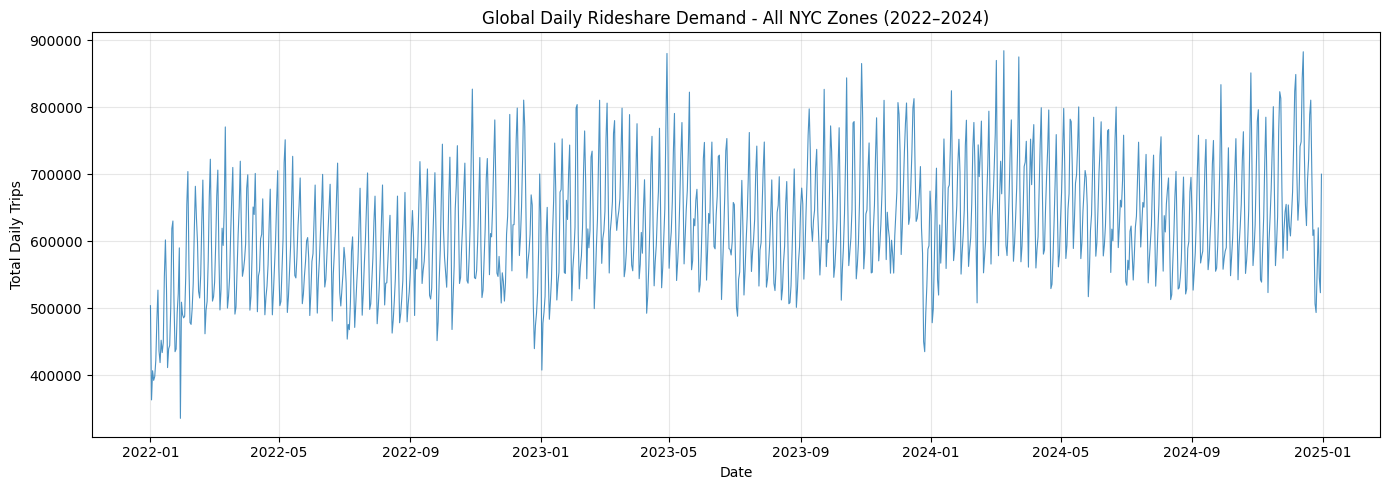


Global Demand Statistics:
  Mean:   623,887 trips/day
  Median: 618,618 trips/day
  Std:    87,630 trips/day
  CV:     0.140 (14.0%)
  Min:    335,385 trips/day
  Max:    884,119 trips/day


In [42]:
# Calculate global daily totals (sum across all zones)
daily_total = zone_daily.groupby('date')['daily_trips'].sum().reset_index()
daily_total.columns = ['date', 'total_trips']

# Plot overall trend
plt.figure(figsize=(14, 5))
plt.plot(daily_total['date'], daily_total['total_trips'], linewidth=0.8, alpha=0.8)
plt.title('Global Daily Rideshare Demand - All NYC Zones (2022–2024)', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Total Daily Trips')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate summary statistics including coefficient of variation
mean_trips = daily_total['total_trips'].mean()
std_trips = daily_total['total_trips'].std()
cv = std_trips / mean_trips

print(f"\nGlobal Demand Statistics:")
print(f"  Mean:   {mean_trips:,.0f} trips/day")
print(f"  Median: {daily_total['total_trips'].median():,.0f} trips/day")
print(f"  Std:    {std_trips:,.0f} trips/day")
print(f"  CV:     {cv:.3f} ({cv*100:.1f}%)")
print(f"  Min:    {daily_total['total_trips'].min():,.0f} trips/day")
print(f"  Max:    {daily_total['total_trips'].max():,.0f} trips/day")

The daily demand chart shows fluctuating volume with possible weekly cycles. There is some indication of a slight increasing trend but is difficult to discern directly from this visual.  Other key observations:

- Possible growth in 2022, then stabilizing in 2023-2024
- Some seasonal dips in the summer and early January
- High standard deviation (±50K trips)
- Relatively stable global day-to-day demand (CV = 14.0%)

### 3.2 Examine Global Demand Stability
Use 30 day rolling statistics to check if daily demand and daily volatility remain consistent throughout the analysis period.

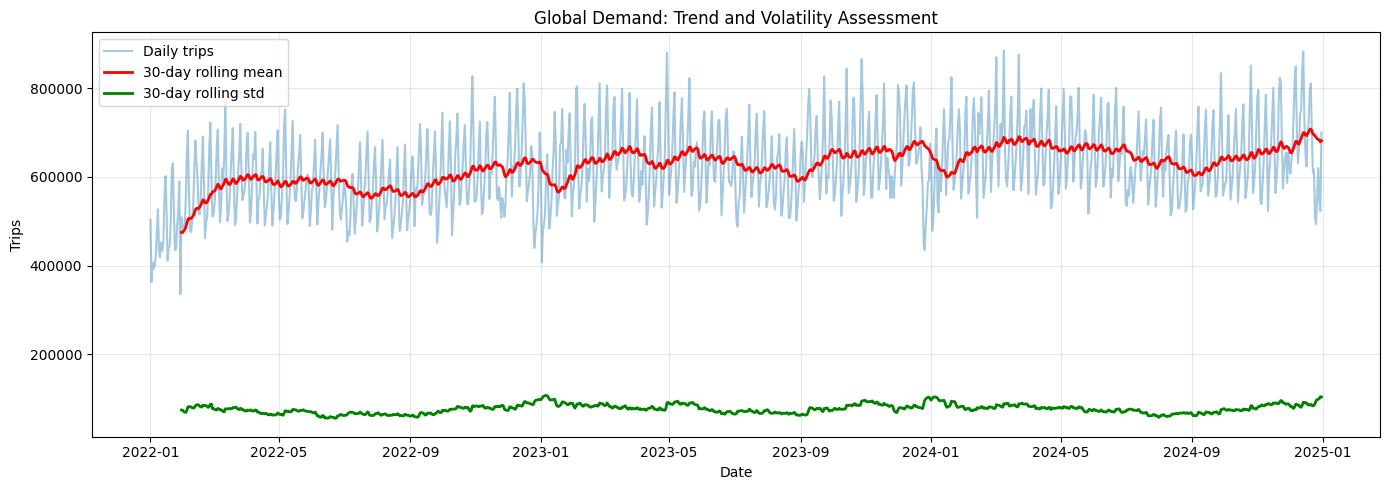

In [43]:
# Create time series with continuous daily index
daily_ts = daily_total.set_index('date')['total_trips'].asfreq('D')

ROLL_DAYS = 30  # 30-day rolling window
rolling_mean = daily_ts.rolling(ROLL_DAYS).mean()
rolling_std = daily_ts.rolling(ROLL_DAYS).std()

# Plot
plt.figure(figsize=(14, 5))
plt.plot(daily_ts.index, daily_ts.values, alpha=0.4, label='Daily trips')
plt.plot(rolling_mean.index, rolling_mean.values, linewidth=2, label=f'{ROLL_DAYS}-day rolling mean', color='red')
plt.plot(rolling_std.index, rolling_std.values, linewidth=2, label=f'{ROLL_DAYS}-day rolling std', color='green')
plt.title('Global Demand: Trend and Volatility Assessment', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Trips')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The 30-day rolling mean (red line) shows the demand level has a slight increasing trend with some seasonal variation: summer lows and winter peaks.

The 30-day rolling std (green line) is somewhat hard to see on this chart due to the scale, but shows relatively consistent day-to-day volatility. There also appears to be some inverse relationship where std is higher during low-demand periods like holidays.

The chart suggests the data may benefit from detrending during the modeling phase.

### 3.3 Examine Global Seasonal Patterns
Examine demand patterns for daily, weekly, and monthly seasonality.

In [44]:
# Calculate average daily trips by day of week
dow_avg = zone_daily.groupby(['day_of_week', 'day_name'])['daily_trips'].mean().reset_index()
dow_avg = dow_avg.sort_values('day_of_week')  # Already in correct order

# Add month_name if not present
if 'month_name' not in zone_daily.columns:
    zone_daily['month_name'] = zone_daily['date'].dt.month_name()

# Calculate average by year and month, keep month number for sorting
monthly_by_year = zone_daily.groupby(['year', 'month', 'month_name'])['daily_trips'].mean().reset_index()
monthly_by_year = monthly_by_year.sort_values(['year', 'month']) 


print("Seasonal aggregations calculated")
monthly_by_year.head()

Seasonal aggregations calculated


,year,month,month_name,daily_trips
0,2022,1,January,1841.6020
1,2022,2,February,2211.1269
2,2022,3,March,2299.1435
3,2022,4,April,2279.9721
4,2022,5,May,2257.0371


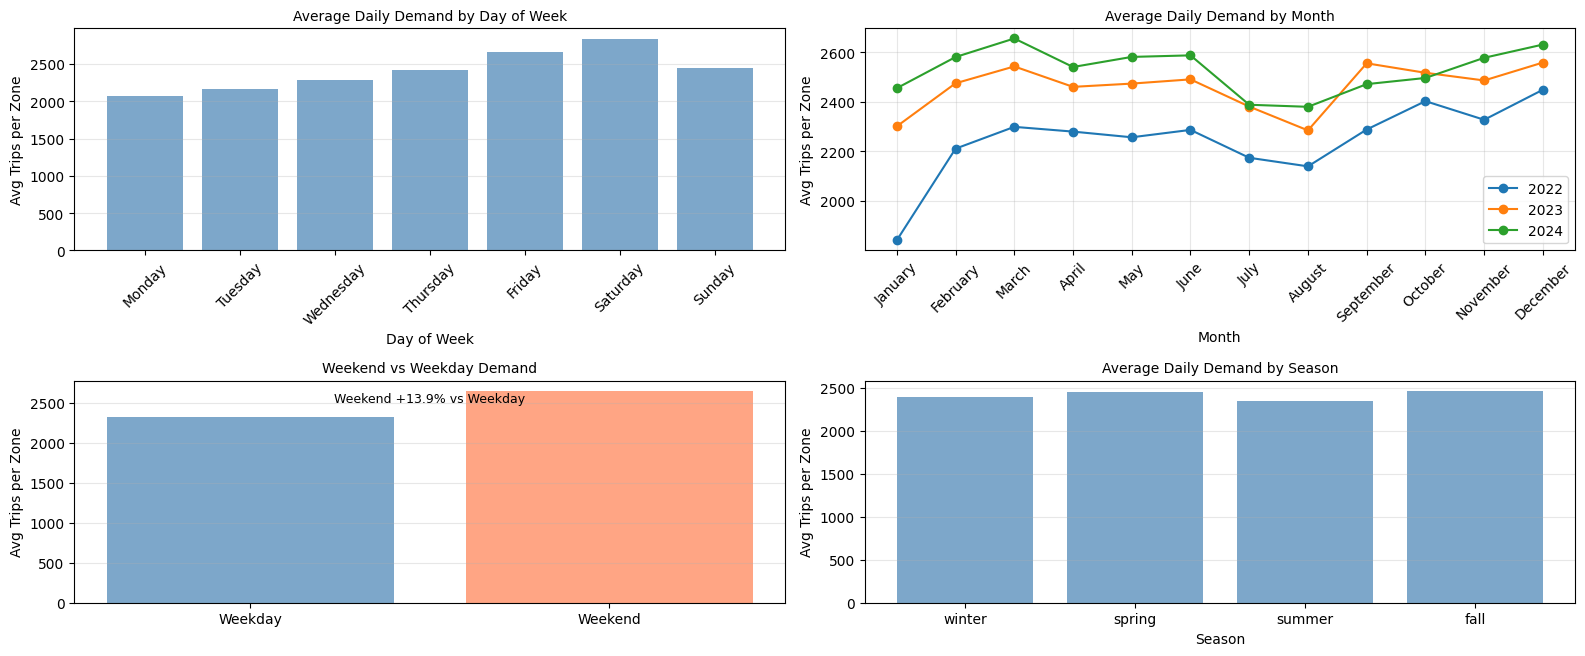

In [45]:
# Visualize global patterns at multiple time scales
fig = plt.figure(figsize=(16, 10))

# Day-of-week patterns
ax2 = fig.add_subplot(3, 2, 3)
ax2.bar(dow_avg['day_name'], dow_avg['daily_trips'], color='steelblue', alpha=0.7)
ax2.set_title('Average Daily Demand by Day of Week', fontsize=10)
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Avg Trips per Zone')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Monthly patterns
ax3 = fig.add_subplot(3, 2, 4)
for year in [2022, 2023, 2024]:
    data = monthly_by_year[monthly_by_year['year'] == year]
    ax3.plot(data['month_name'], data['daily_trips'], marker='o', label=str(year))
ax3.set_title('Average Daily Demand by Month', fontsize=10)
ax3.set_xlabel('Month')
ax3.set_ylabel('Avg Trips per Zone')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Weekend vs Weekday
ax4 = fig.add_subplot(3, 2, 5)
weekend_avg = zone_daily[zone_daily['is_weekend']]['daily_trips'].mean()
weekday_avg = zone_daily[~zone_daily['is_weekend']]['daily_trips'].mean()
ax4.bar(['Weekday', 'Weekend'], [weekday_avg, weekend_avg], color=['steelblue', 'coral'], alpha=0.7)
ax4.set_title('Weekend vs Weekday Demand', fontsize=10)
ax4.set_ylabel('Avg Trips per Zone')
ax4.grid(True, alpha=0.3, axis='y')
pct_diff = ((weekend_avg - weekday_avg) / weekday_avg * 100)
ax4.text(0.5, 0.95, f'Weekend {pct_diff:+.1f}% vs Weekday', 
         transform=ax4.transAxes, ha='center', va='top', fontsize=9)

# Seasonal patterns
ax5 = fig.add_subplot(3, 2, 6)
season_avg = zone_daily.groupby('season')['daily_trips'].mean().reindex(['winter', 'spring', 'summer', 'fall'])
ax5.bar(season_avg.index, season_avg.values, color='steelblue', alpha=0.7)
ax5.set_title('Average Daily Demand by Season', fontsize=10)
ax5.set_xlabel('Season')
ax5.set_ylabel('Avg Trips per Zone')
ax5.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Demand shows clear seasonal patterns across multiple time scales:

- **Weekly:** Demand builds through the week, peaking Saturday, weekend days have slightly higher demand (+13%)
- **Monthly:** Summer months (June-August) show consistent lows; December shows peak demand
- **Annual:** 2022 show modest growth trend that stabilizes in 2023-2024
- **Seasonal:** Winter highest, summer lowest

These patterns indicate seasonality will need to be addressed in the forecasting model.

## 4. Analyze Zone Demand Patterns
Examine how individual zones differ in volume, variability, and temporal patterns.

### 4.1 Check Temporal Coverage
Verify that all zones have complete daily records across the analysis period.

In [46]:
# Calculate expected days in date range
expected_days = (zone_daily['date'].max() - zone_daily['date'].min()).days + 1

# Count actual days with data for each zone and identify missing days
daily_coverage = zone_daily.groupby('zone_id')['date'].nunique().reset_index()
daily_coverage.columns = ['zone_id', 'days_with_data']
daily_coverage['missing_days'] = expected_days - daily_coverage['days_with_data']

# Identify complete vs incomplete zones
zones_complete = daily_coverage[daily_coverage['missing_days'] == 0]['zone_id'].tolist()
zones_incomplete = daily_coverage[daily_coverage['missing_days'] > 0]['zone_id'].tolist()

# Calculate data impact
total_records = len(zone_daily)
incomplete_records = len(zone_daily[zone_daily['zone_id'].isin(zones_incomplete)])
pct_zones_complete = len(zones_complete) / len(daily_coverage) * 100
pct_data_incomplete = incomplete_records / total_records * 100

# Display results
print(f"Expected days per zone: {expected_days}")
print(f"Zones with complete coverage: {len(zones_complete)} / {len(daily_coverage)} ({pct_zones_complete:.1f}%)")
print(f"Data from incomplete zones: {incomplete_records:,} / {total_records:,} records ({pct_data_incomplete:.2f}%)")

if zones_incomplete:
    print(f"\nZones with missing days: {len(zones_incomplete)}")
    display(daily_coverage[daily_coverage['zone_id'].isin(zones_incomplete)])

Expected days per zone: 1096
Zones with complete coverage: 256 / 263 (97.3%)
Data from incomplete zones: 2,952 / 283,528 records (1.04%)

Zones with missing days: 7


,zone_id,days_with_data,missing_days
0,1,44,1052
1,2,757,339
102,105,118,978
107,110,669,427
196,199,268,828
250,253,1095,1
261,264,1,1095


The seven incomplete zones represent only 1.04% of total records. These will be removed to avoid imputation in the modeling stage.

In [47]:
# Filter zones with gaps to avoid imputation in modeling stage
zone_daily = zone_daily[zone_daily['zone_id'].isin(zones_complete)].reset_index(drop=True)

# Re-save filtered dataset (overwrites previous save for modeling pipeline)
zone_daily.to_parquet(OUTPUT_FILE, index=False)

print(f"Zones retained: {len(zones_complete)}")
print("Filtered to zones with complete daily records")
print(f"Re-saved filtered dataset: {OUTPUT_FILE.name}")
print(f"Records: {len(zone_daily):,}")
print(f"Zones: {zone_daily['zone_id'].nunique()}")

Zones retained: 256
Filtered to zones with complete daily records
Re-saved filtered dataset: zone_daily.parquet
Records: 280,576
Zones: 256


### 4.2 Review Zone Volume Distribution

In [48]:
# Calculate total trips per zone
zone_totals = zone_daily.groupby('zone_id')['daily_trips'].sum().reset_index()
zone_totals.columns = ['zone_id', 'total_trips']
zone_totals = zone_totals.sort_values('total_trips', ascending=False).reset_index(drop=True)
zone_totals['pct_of_total'] = (zone_totals['total_trips'] / zone_totals['total_trips'].sum() * 100).round(2)
zone_totals['cumulative_pct'] = zone_totals['pct_of_total'].cumsum()

print(" Zone volume metrics calculated")

 Zone volume metrics calculated


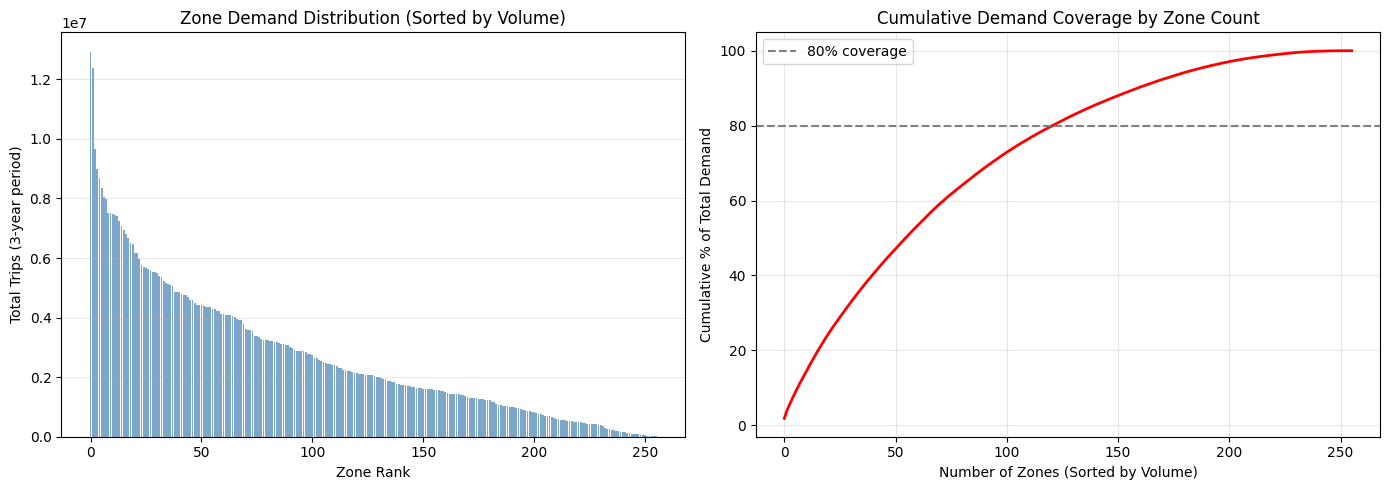


Cumulative demand coverage:
  Top  10 zones:  13.5%
  Top  20 zones:  23.7%
  Top  50 zones:  46.5%
  Top 100 zones:  72.5%
  Top 150 zones:  87.8%
  Top 200 zones:  96.9%

  Total zones: 256


In [49]:
# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Zone volume distribution
ax1.bar(range(len(zone_totals)), zone_totals['total_trips'], color='steelblue', alpha=0.7)
ax1.set_title('Zone Demand Distribution (Sorted by Volume)', fontsize=12)
ax1.set_xlabel('Zone Rank')
ax1.set_ylabel('Total Trips (3-year period)')
ax1.grid(True, alpha=0.3, axis='y')

# Cumulative coverage
ax2.plot(range(len(zone_totals)), zone_totals['cumulative_pct'], linewidth=2, color='red')
ax2.set_title('Cumulative Demand Coverage by Zone Count', fontsize=12)
ax2.set_xlabel('Number of Zones (Sorted by Volume)')
ax2.set_ylabel('Cumulative % of Total Demand')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=80, color='gray', linestyle='--', label='80% coverage')
ax2.legend()

plt.tight_layout()
plt.show()

# Coverage statistics
print("\nCumulative demand coverage:")
for n in [10, 20, 50, 100, 150, 200]:
    if n <= len(zone_totals):
        pct = zone_totals.iloc[:n]['cumulative_pct'].iloc[-1]
        print(f"  Top {n:3d} zones: {pct:5.1f}%")

print(f"\n  Total zones: {len(zone_totals)}")

Demand is spread across zones rather than concentrated in a few high-volume with the top 100 zones contain 72.5% of trips.  This indicates most zones contribute meaningful demand levels rather than a few zones dominating.

### 4.3 Analyze Zone Variability 
Calculate coefficient of variation (CV) to measure demand stability within each zone.

Zone Variability Summary:
Highest avg daily demand: 11,800 trips/day
Lowest avg daily demand:  13 trips/day
Most volatile zone (CV):  1.334
Most stable zone (CV):    0.113
Median CV:                0.173


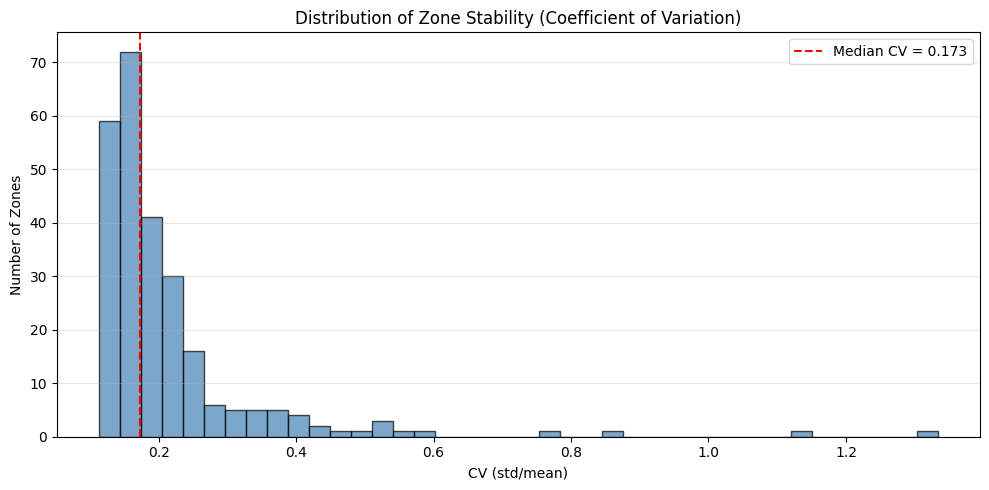

 Saved zone statistics: zone_stats_summary.csv


In [50]:
# Calculate zone-level statistics
zone_stats = zone_daily.groupby('zone_id').agg({
    'daily_trips': ['sum', 'mean', 'median', 'std', 'min', 'max'],
    'daily_avg_minutes': 'mean',
    'avg_trip_miles': 'mean'
}).round(2)

# Flatten column names
zone_stats.columns = ['_'.join(col).strip() for col in zone_stats.columns.values]
zone_stats = zone_stats.reset_index()

# Calculate coefficient of variation (CV = std/mean)
zone_stats['cv'] = (zone_stats['daily_trips_std'] / zone_stats['daily_trips_mean']).round(3)

# Summary statistics
print("Zone Variability Summary:")
print(f"Highest avg daily demand: {zone_stats['daily_trips_mean'].max():,.0f} trips/day")
print(f"Lowest avg daily demand:  {zone_stats['daily_trips_mean'].min():,.0f} trips/day")
print(f"Most volatile zone (CV):  {zone_stats['cv'].max():.3f}")
print(f"Most stable zone (CV):    {zone_stats['cv'].min():.3f}")
print(f"Median CV:                {zone_stats['cv'].median():.3f}")

# Visualize CV distribution
plt.figure(figsize=(10, 5))
plt.hist(zone_stats['cv'], bins=40, color='steelblue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Zone Stability (Coefficient of Variation)', fontsize=12)
plt.xlabel('CV (std/mean)')
plt.ylabel('Number of Zones')
plt.axvline(x=zone_stats['cv'].median(), color='red', linestyle='--', label=f'Median CV = {zone_stats["cv"].median():.3f}')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Save zone statistics
zone_stats.to_csv(ZONE_STATS_FILE, index=False)
print(f" Saved zone statistics: {ZONE_STATS_FILE.name}")

Zone volumes range widely from 13 to 11,800 trips/day, but most zones show stable within-zone demand patterns. The median CV of 0.174 indicates low day-to-day variability. This may support a straightforward modeling approach using lag-based forecasting.

### 4.4 Analyze Zone Correlations
Measure how strongly zones move together. This helps determine if temporal patterns are shared across zones. 

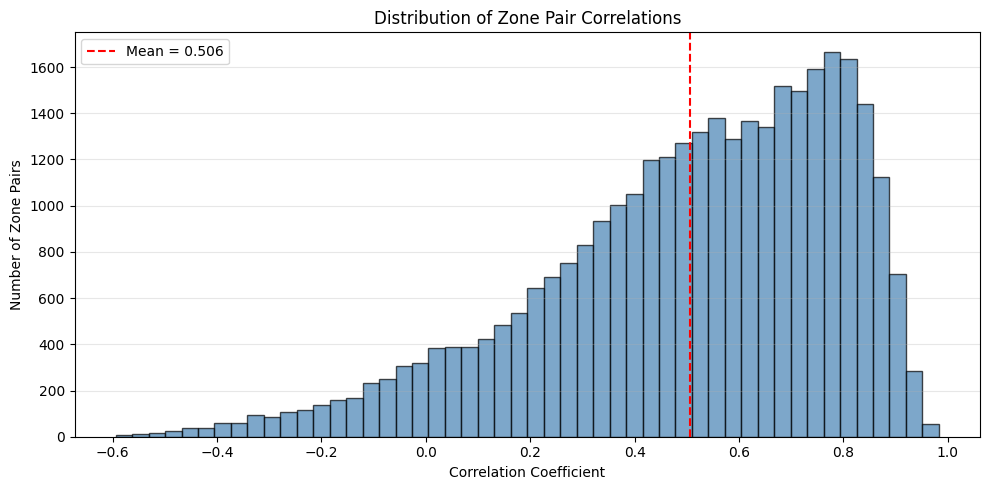


Zone Correlation Summary (32,640 pairs analyzed):
  High correlation (>0.7):  9,975 (30.6%)
  Medium correlation (0.4-0.7): 12,422 (38.1%)
  Low correlation (<0.4):   10,243 (31.4%)

  Mean correlation: 0.506
  Median correlation: 0.554


In [51]:
# Create correlation matrix (sample if too many zones)
pivot = zone_daily.pivot_table(index='date', columns='zone_id', values='daily_trips')

# Sample zones if too many (correlation matrix is memory intensive)
MAX_ZONES = 256
if pivot.shape[1] > MAX_ZONES:
    top_zones = zone_totals['zone_id'].head(MAX_ZONES).tolist()
    pivot = pivot[top_zones]
    print(f"Sampled top {MAX_ZONES} zones for correlation analysis")

corr_matrix = pivot.corr()

# Extract upper triangle (avoid double-counting)
upper_triangle = np.triu(corr_matrix, k=1)
correlations = upper_triangle[upper_triangle != 0]

# Visualize correlation distribution
plt.figure(figsize=(10, 5))
plt.hist(correlations, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Zone Pair Correlations', fontsize=12)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Number of Zone Pairs')
plt.axvline(x=correlations.mean(), color='red', linestyle='--', label=f'Mean = {correlations.mean():.3f}')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Summary statistics
high_corr = (correlations > 0.7).sum()
med_corr = ((correlations > 0.4) & (correlations <= 0.7)).sum()
low_corr = (correlations <= 0.4).sum()

print(f"\nZone Correlation Summary ({len(correlations):,} pairs analyzed):")
print(f"  High correlation (>0.7):  {high_corr:,} ({high_corr/len(correlations)*100:.1f}%)")
print(f"  Medium correlation (0.4-0.7): {med_corr:,} ({med_corr/len(correlations)*100:.1f}%)")
print(f"  Low correlation (<0.4):   {low_corr:,} ({low_corr/len(correlations)*100:.1f}%)")
print(f"\n  Mean correlation: {correlations.mean():.3f}")
print(f"  Median correlation: {np.median(correlations):.3f}")

Moderate correlations (median 0.55) indicate zones may share temporal patterns. This supports a multi-series forecasting approach using a single model for all zones.

---

## 5. Save Final Dataset
Export filtered dataset for use in forecasting notebook.

In [54]:
# Save processed dataset for forecasting pipeline

zone_daily.to_parquet(OUTPUT_FILE, index=False)

print("FINAL DATASET EXPORT")
print("=" * 50)
print(f"  Saved: {OUTPUT_FILE.name}")
print(f"  Zones: {zone_daily['zone_id'].nunique()} (complete coverage only)")
print(f"  Records: {len(zone_daily):,}")
print(f"  Date range: {zone_daily['date'].min().date()} to {zone_daily['date'].max().date()}")
print(f"  Features: {len(zone_daily.columns)}")
print(f"  Size: {OUTPUT_FILE.stat().st_size / 1024 / 1024:.1f} MB")
print(f"\nReady for forecasting notebook: 03_demand_forecasting.ipynb")

FINAL DATASET EXPORT
  Saved: zone_daily.parquet
  Zones: 256 (complete coverage only)
  Records: 280,576
  Date range: 2022-01-01 to 2024-12-31
  Features: 17
  Size: 14.0 MB

Ready for forecasting notebook: 03_demand_forecasting.ipynb


## Conclusion

This notebook aggregated 683M validated NYC rideshare trip records to daily counts by zone. The data was then analyzed for demand patterns using a two-level approach: system-wide trends first, then individual zone characteristics.

**Key Findings:**

*Global Demand Patterns:*
- Weekend demand runs about 13% higher than weekdays
- Moderate seasonal patterns with summer lows and winter peaks, though weaker than weekly patterns
- Slight growth in 2022, then stabilized in 2023-2024

*Zone-Level Characteristics:*
- 256 zones included after removing 7 with incomplete temporal coverage
- Zone volumes range widely from 13 to 11,800 trips/day
- Within-zone demand is generally stable with low day-to-day volatility (median CV 0.17)
- Moderate cross-zone correlations (median 0.55) indicate shared temporal patterns

**Technical Decisions:**
- Used 30-day rolling statistics to check for trend changes over time
- Calculated coefficient of variation to measure demand stability within each zone
- Removed zones with incomplete data to avoid imputation
- Added 7 calendar features: year, month, day_of_week, day_name, is_weekend, season, is_holiday

**Modeling Implications:**
- Moderate correlations (0.55) support a global model
- Low within-zone variability (CV 0.17) supports simple lag-based features
- Stable trends suggest simpler models may perform well without complex transformations
- *Weekly patterns appear stronger than yearly/monthly seasonal patterns* — simple lag features may outperform complex decomposition methods

**Outputs:**
- `zone_daily.parquet` — Daily trip counts by zone with calendar features
- `zone_stats_summary.csv` — Zone-level summary statistics

**Next Steps:**
Proceed to **03_demand_forecasting.ipynb** for feature engineering and model development.